In [1]:
import requests
import pandas as pd
from io import StringIO

def fetch_kepler_system(system_name='Kepler-223'):
    """
    Fetches masses and orbital parameters of the star and planets
    in the specified system from NASA Exoplanet Archive.

    Parameters
    ----------
    system_name : str
        Name of the planetary system (e.g., 'Kepler-223')

    Returns
    -------
    star_data : dict
        Dictionary of stellar parameters
    planet_df : pd.DataFrame
        DataFrame of planetary parameters
    """

    # Query combined planet and stellar data from pscomppars
    url = "https://exoplanetarchive.ipac.caltech.edu/TAP/sync"
    query = f"""
    SELECT pl_name, hostname, pl_orbper, pl_orbsmax, pl_orbeccen, pl_orbincl,
           pl_masse, pl_msinie, pl_bmasse, pl_rade,
           st_mass, st_rad, st_teff
    FROM pscomppars
    WHERE hostname='{system_name}'
    """

    response = requests.get(url, params={
        "query": query,
        "format": "csv"
    })

    if response.status_code != 200:
        raise Exception(f"Failed to fetch data: {response.status_code}\n{response.text}")

    df = pd.read_csv(StringIO(response.text))
    
    # Extract stellar data from the first row (same for all planets)
    star_cols = ['hostname', 'st_mass', 'st_rad', 'st_teff']
    star_data = df[star_cols].iloc[0].to_dict()

    # Drop duplicate star columns from planet table
    planet_df = df.drop(columns=[col for col in star_cols if col != 'hostname'])

    return star_data, planet_df

# Example usage
if __name__ == "__main__":
    star, planets = fetch_kepler_system("Kepler-223")

    print("Stellar Parameters:")
    for k, v in star.items():
        print(f"  {k}: {v}")

    print("\nPlanetary Parameters:")
    print(planets)


Stellar Parameters:
  hostname: Kepler-223
  st_mass: 1.125
  st_rad: 1.72
  st_teff: 5803.0

Planetary Parameters:
        pl_name    hostname  pl_orbper  pl_orbsmax  pl_orbeccen  pl_orbincl  \
0  Kepler-223 d  Kepler-223   14.78869     0.11956        0.037       87.94   
1  Kepler-223 b  Kepler-223    7.38449     0.07525        0.078       90.00   
2  Kepler-223 c  Kepler-223    9.84564     0.09117        0.150       90.00   
3  Kepler-223 e  Kepler-223   19.72567     0.14481        0.051       88.00   

   pl_masse  pl_msinie  pl_bmasse  pl_rade  
0       8.0        NaN        8.0     5.24  
1       7.4        NaN        7.4     2.99  
2       5.1        NaN        5.1     3.44  
3       4.8        NaN        4.8     4.60  


In [2]:
import numpy as np
iorder = np.argsort(planets.pl_orbper)
masses =np.array(3e-6 * planets.pl_masse / star['st_mass'])[iorder]
periods = np.array(planets.pl_orbper[iorder])
resonances = [(j,1) for j in np.round(1 + 1/(periods[1:]/periods[:-1]-1)).astype(int)]


In [4]:
import sys
sys.path.append("../../22_chain_dynamics/")


from resonant_chains import ResonantChainPoissonSeries
import celmech as cm

from celmech.poisson_series import PSTerm, PoissonSeries

import sympy as sp

In [9]:
from resonant_chains import get_chain_rebound_sim
def get_chain_hpert(resonances, max_order,max_order_dl = 1):
    sim = get_chain_rebound_sim(resonances,masses)
    pvars = cm.Poincare.from_Simulation(sim)
    pham = cm.PoincareHamiltonian(pvars)
    periods = []
    period = 1
    periods.append(period)
    for j,k in resonances:
        period *= j/sp.S(j-k)
        periods.append(period)
    hpert_series_terms = []
    
    ei_order = lambda k,nu: np.sum(np.abs(k[2:])) + 2*np.sum(nu)
    for i1,p1 in enumerate(periods):
        for i2,p2 in zip(range(i1+1,len(periods)),periods[i1+1:]):
            pratio = p2/p1
            p,q = int(sp.numer(pratio)),int(sp.numer(pratio) - sp.denom(pratio))
            resonant_terms = cm.disturbing_function.list_resonance_terms(p,q,max_order = max_order)
            if len(resonant_terms)>0:
                print("adding terms for {}:{} MMR between {} and {}".format(p,q,i1+1,i2+1))
            for k,nu in resonant_terms:
                hpert_series_terms += cm.poisson_series.DFTerm_as_PSterms(pham,i1+1,i2+1,k,nu,(0,0))
                if ei_order(k,nu) <= max_order_dl:
                    hpert_series_terms += cm.poisson_series.DFTerm_as_PSterms(pham,i1+1,i2+1,k,nu,(1,0))
                    hpert_series_terms += cm.poisson_series.DFTerm_as_PSterms(pham,i1+1,i2+1,k,nu,(0,1))
                
    secular_terms = cm.disturbing_function.list_secular_terms(min_order=0,max_order = max_order)
    for k,nu in secular_terms:
        for i1 in range(1,sim.N):
            for i2 in range(i1+1,sim.N):
                hpert_series_terms += cm.poisson_series.DFTerm_as_PSterms(pham,i1,i2,k,nu,(0,0))
                if ei_order(k,nu) <= max_order_dl:
                    hpert_series_terms += cm.poisson_series.DFTerm_as_PSterms(pham,i1,i2,k,nu,(1,0))
                    hpert_series_terms += cm.poisson_series.DFTerm_as_PSterms(pham,i1,i2,k,nu,(0,1))
    return PoissonSeries.from_PSTerms(hpert_series_terms)

In [113]:
hpert_series = get_chain_hpert(resonances,3,1)
rc_poisson = ResonantChainPoissonSeries(resonances,masses,hpert_series)

adding terms for 4:1 MMR between 1 and 2
adding terms for 2:1 MMR between 1 and 3
adding terms for 3:1 MMR between 2 and 3
adding terms for 2:1 MMR between 2 and 4
adding terms for 4:1 MMR between 3 and 4


In [114]:
Ndim = 2 * (rc_poisson.M + rc_poisson.N_planar)
rc_poisson.dK2 = 0
guess = np.zeros(Ndim)
guess[rc_poisson.N_planar] = 90*np.pi/180
guess[rc_poisson.N_planar+1] = -90*np.pi/180
guess = newton_solve2(rc_poisson.planar_flow_and_jacobian,guess)
    
eigs = np.linalg.eigvals(rc_poisson.planar_jacobian(guess))
re_eigs = np.real(eigs)
re_eigs[np.isclose(re_eigs,0)]=0
print(re_eigs)
print(np.imag(eigs))

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.00930002 -0.00930002  0.00406394 -0.00406394  0.00293499 -0.00293499
  0.0009413  -0.0009413   0.00199059 -0.00199059  0.00190801 -0.00190801]


In [255]:
from resonant_chains import newton_solve2,_get_nu_from_resonances

In [262]:
_get_nu_from_resonances(resonances) / 3 /3 /2

⎡8⎤
⎢ ⎥
⎢6⎥
⎢ ⎥
⎢4⎥
⎢ ⎥
⎣3⎦

In [259]:
rc_poisson.Tmtrx_inv.T[0]

array([8., 6., 4., 3., 0., 0., 0., 0., 0., 0., 0., 0.])

In [116]:
N = 20
eigs= np.zeros((N,Ndim),dtype=complex)
periods = np.zeros((N,4))
eccentricities = np.zeros((N,4))
eqs = np.zeros((N,guess.size))
dK2vals =  np.linspace(0,-0.003,N)
for i,dK2 in enumerate(dK2vals):
    rc_poisson.dK2 = dK2
    guess = newton_solve2(rc_poisson.planar_flow_and_jacobian,guess)
    pvars = rc_poisson.real_planar_vars_to_pvars(guess)
    eigs[i] = np.linalg.eigvals(rc_poisson.planar_jacobian(guess))
    periods[i] = [p.P for p in pvars.particles[1:]]
    eccentricities[i] = [p.e for p in pvars.particles[1:]]
    eqs[i] = guess

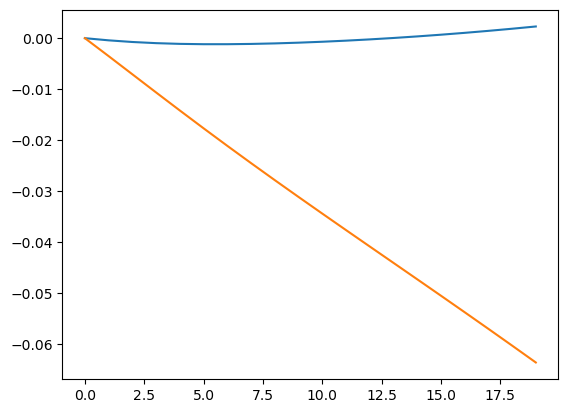

In [117]:
plt.plot(eqs[:,4]-eqs[0,4])
plt.plot(eqs[:,5]-eqs[0,5])

In [125]:
Deltas = [(jk[0]-jk[1])*ratio / jk[0] - 1 for jk,ratio in zip(resonances,(periods[:,1:]/periods[:,:-1]).T)]

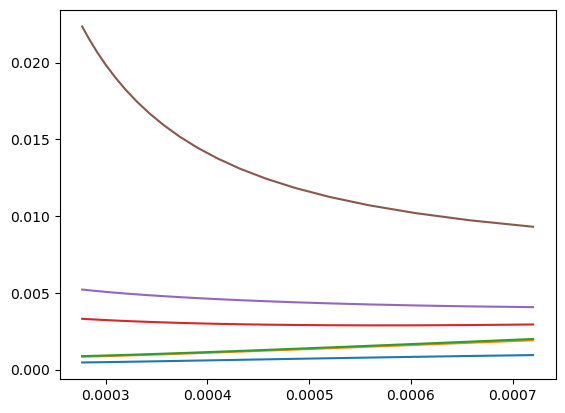

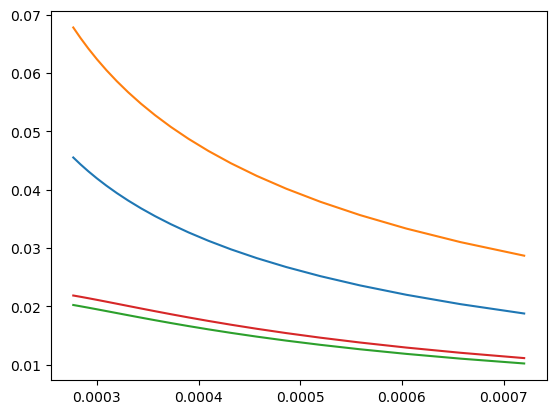

In [126]:
re_eigs = np.real(eigs)
re_eigs[np.isclose(re_eigs,0)]=0
freqs = np.sort(np.imag(eigs),axis=1)[:,Ndim//2:]

plt.plot(Deltas[0],freqs)
plt.figure()
plt.plot(Deltas[0],eccentricities)

In [102]:
from scipy.integrate import solve_ivp

In [103]:
soln = solve_ivp(
    lambda t,y: rc_poisson.planar_flow(y),
    (0,10_000),
    guess + 1e-5 * np.random.normal(size=Ndim),
    method='Radau',
    jac = lambda t,y: rc_poisson.planar_jacobian(y)
)

In [104]:
from matplotlib import pyplot as plt


In [105]:
Ndim//2

6

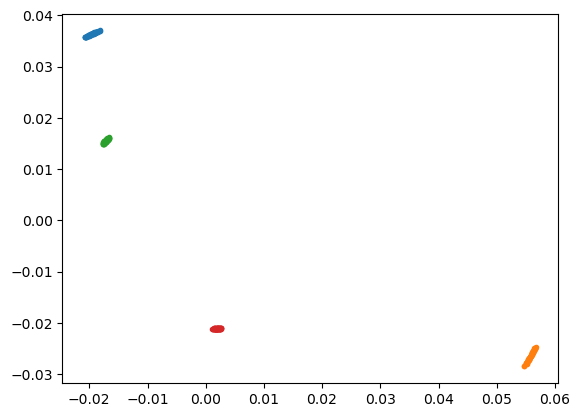

In [106]:
for i in range(4):

    plt.plot(soln.y[i],soln.y[Ndim//2 + i],'.')

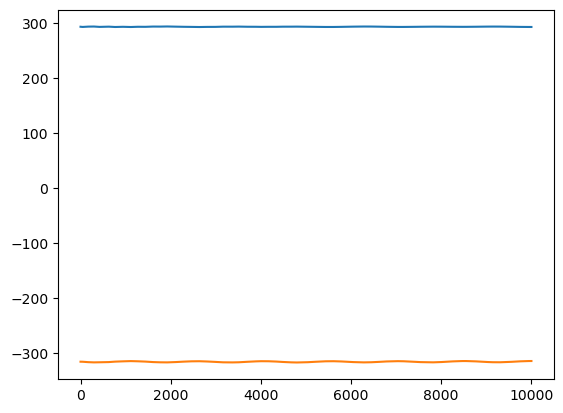

In [107]:
plt.plot(soln.t,soln.y[rc_poisson.N_planar]*180/np.pi)
plt.plot(soln.t,soln.y[rc_poisson.N_planar+1]*180/np.pi)

In [ ]:
rc_poisson._pl

In [132]:
from resonant_chains import _real_flow

rc_poisson.complex_full_flow_list

In [131]:
from resonant_chains import hamiltonian_series_to_flow_series_list
hamiltonian_series_to_flow_series_list(rc_poisson.h_full_series)

In [211]:
from resonant_chains import hamiltonian_series_to_flow_series_list
from resonant_chains import real_vars_jacobian_series,_real_flow
# reduced planar hamiltonian
term_deg = lambda term: np.sum(term.p) + 0.5*np.sum(term.k + term.kbar)
N_planar = rc_poisson.h_full_series.N // 2
planar_terms = [
    PSTerm(
        term.C * rc_poisson.action_scale**(term_deg(term)-1),
        term.k[:N_planar],
        term.kbar[:N_planar],
        term.p[1:],
        term.q[1:]
    )
    for term in rc_poisson.h_full_series.terms
    if np.alltrue(term.k[N_planar:]==0) and np.alltrue(term.kbar[N_planar:]==0) and term.p[0]==0
]
h_planar_series = PoissonSeries.from_PSTerms(planar_terms)
planar_complex_flow_list = hamiltonian_series_to_flow_series_list(h_planar_series)
planar_jacobian_list = real_vars_jacobian_series(planar_complex_flow_list)
assert np.alltrue([term.q[0]==0 for term in h_planar_series.terms])

In [213]:
XX=np.concatenate((
    guess[:rc_poisson.N_planar],
    [0],
    guess[rc_poisson.N_planar:2*rc_poisson.N_planar+rc_poisson.M],
    [rc_poisson.dK2],
    guess[-rc_poisson.M:]
    )
)

In [254]:
asdf = _real_flow(
    XX,
    planar_complex_flow_list,
    h_planar_series.N,
    h_planar_series.M
)
N = rc_poisson.N_planar
M = rc_poisson.M
arr = asdf
# #y, Qrest + x
np.concatenate((arr[:N],arr[N+1:2*N+M+1],arr[2*N+M+2:],[arr[2*N+M+1]]))


array([-4.77801892e-19, -3.36624537e-19,  1.45318483e-19, -5.80001177e-19,
        5.14996032e-19,  1.81603864e-18, -1.65393739e-19,  1.25793329e-18,
       -1.45096219e-19, -2.96476657e-20, -2.32222685e-20, -1.48462376e-20,
        0.00000000e+00])

In [245]:
indices = np.indices(asdf.shape)[0]
indices = np.delete(indices,h_planar_series.N+1)
indices[(-1,)] = indices[(,-1)]

In [247]:
asdf[]

array([-4.77801892e-19, -3.36624537e-19,  1.45318483e-19, -5.80001177e-19,
       -8.52705224e-04,  1.81603864e-18, -1.65393739e-19,  1.25793329e-18,
       -1.45096219e-19, -2.96476657e-20,  0.00000000e+00, -2.32222685e-20,
       -1.48462376e-20])

In [237]:
indices = np.arange(2*(N+M+1))

array([-4.77801892e-19, -3.36624537e-19,  1.45318483e-19, -5.80001177e-19,
       -8.52705224e-04,  5.14996032e-19,  1.81603864e-18, -1.65393739e-19,
        1.25793329e-18, -1.45096219e-19, -2.96476657e-20,  0.00000000e+00,
       -2.32222685e-20, -1.48462376e-20])

In [236]:
asdf[2 * rc_poisson.N_planar + rc_poisson.M + 1]

0.0

In [235]:
np.arange(rc_poisson.N_planar),np.arange(rc_poisson.N_planar+1,rc_poisson.N_planar+1+rc_poisson.M)

(array([0, 1, 2, 3]), array([5, 6]))

In [232]:
asdf[:rc_poisson.N_planar]

array([-4.77801892e-19, -3.36624537e-19,  1.45318483e-19, -5.80001177e-19])

In [228]:
rc_poisson.planar_flow(guess)

array([-3.15937617e-19, -5.18253924e-19,  1.93982580e-19, -4.19933729e-19,
        1.31713623e-19,  1.81942677e-18, -1.55211712e-19,  1.52685858e-18,
       -9.61326495e-20, -3.08455512e-20, -5.65956975e-21, -2.77601814e-21])

In [220]:
import numpy as np

def rearrange_array(arr, N, M):
    """
    Rearranges a numpy array of length 2*(N+M)+1 into a new array of length 2*(N+M+1)
    according to the specified pattern.

    Parameters
    ----------
    arr : numpy.ndarray
        Input array of length 2*(N+M)+1.
    N : int
        Number of initial and middle entries to preserve.
    M : int
        Number of entries between the inserted zero and the middle N.

    Returns
    -------
    numpy.ndarray
        Rearranged array of length 2*(N+M+1).
    """
    assert len(arr) == 2 * (N + M) + 1, "Input array must have length 2*(N+M)+1"
    
    part1 = arr[:N]
    zero = np.array([0])
    part2 = arr[N:N+(M+N)]
    part3 = np.array([arr[-1]])
    part4 = arr[2*N+M:2*N+2*M]

    return np.concatenate([part1, zero, part2, part3, part4])


In [223]:
result = rearrange_array(np.concatenate((guess,[rc_poisson.dK2])),h_planar_series.N,h_planar_series.M-1)

In [224]:
XX-result

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])